# Laboratorium 4

Importowanie bibliotek:

In [1]:
import numpy as np 
import networkx as nx
from collections import deque
from math import inf
from sklearn.utils.extmath import randomized_svd

### Algorytm permutacji minimum degree 

Algorytm minimum degree jest używany w analizie numerycznej do permutacji wierszy i kolumn symetrycznej rzadkiej macierzy przed zastosowaniem rozkładu Cholesky'ego. Celem jest zmniejszenie liczby niezerowych elementów w czynniku Cholesky'ego, co prowadzi do zmniejszenia wymagań pamięciowych i umożliwia zastosowanie czynnika Cholesky'ego z mniejszą liczbą operacji arytmetycznych.

Algorytmy minimum degree są często stosowane w metodzie elementów skończonych, gdzie przestawienie węzłów może być przeprowadzone tylko na podstawie topologii siatki, a nie współczynników w równaniu różniczkowym cząstkowym. Daje to oszczędności efektywności, gdy ta sama siatka jest używana dla różnych wartości współczynników.

#### Pseudokod:

Dla symetrycznej macierzy $M$ o rozmiarze $n$ x $n$:

* Dla danego grafu $G_0$ = (V, E), gdzie V to zbiór wierzchołków, a E to zbiór krawędzi, jeżeli w i-tym wierszy i j-tej kolumnie jest wartość niezerowa to w tamtym miejscu znajduje się krawędź, $|V|$ = $n$

* Zdefiniuj R = [] jako pustą listę permutacji.
* Dla i = 1 do n (gdzie n to liczba wierzchołków w V):
   *  Znajdź wierzchołek v w $G_{i-1}$ o najmniejszym stopniu.
   *  Dodaj v do R.
   *  $G_i$ = $G_{i-1}$ (bez wierzchołka v)
* Zwróć R.

In [2]:
def minimum_degree_permutation(matrix):
    """
    Returns the minimum degree permutation of the given matrix.
    """
    n,m = matrix.shape
    adjacencies_matrix = {i:set() for i in range(n)}

    for i in range(n):
        for j in range(m):
            if matrix[i,j] != 0 and i != j:
                adjacencies_matrix[i].add(j)

    permutation = []

    for i in range(n):
        min_degree = m+1

        for v, adj in adjacencies_matrix.items():
            if len(adj) < min_degree:
                min_degree = len(adj)
                min_degree_node = v

        for v in adjacencies_matrix:
            adjacencies_matrix[v] = adjacencies_matrix[v].difference([min_degree_node])

        for u in adjacencies_matrix[min_degree_node]:
            adjacencies_matrix[u] = (adjacencies_matrix[u].union(adjacencies_matrix[min_degree_node].difference([u])))
            
        adjacencies_matrix.pop(min_degree_node)
        permutation.append(min_degree_node)

    return permutation

def permutate(matrix, permutation):
    new_matrix = matrix.copy()
    for i in range(len(permutation)):
        if i == permutation[i]:
            continue
        new_matrix[i,:] = matrix[permutation[i],:].copy()

    matrix = new_matrix.copy()
    for i in range(len(permutation)):
        if i == permutation[i]:
            continue
        new_matrix[:,i] = matrix[:,permutation[i]].copy()

    return new_matrix

### Algorytm permutacji Cuthill Mckee

Algorytm Cuthill-McKee (CM) w numerycznej algebrze liniowej służy do permutacji rzadkiej macierzy o symetrycznym wzorcu rzadkości do formy macierzy pasmowej o małej szerokości pasma. Odwrócony algorytm Cuthill-McKee (RCM) to ten sam algorytm, ale z odwróconymi wynikowymi numerami indeksów. W praktyce RCM zazwyczaj prowadzi do mniejszego 'fill-in' niż porządek CM po zastosowaniu eliminacji Gaussa.

#### Pseudokod:

Dla symetrycznej macierzy $M$ o rozmiarze $n$ x $n$:

* Dla danego grafu $G_0$ = (V, E), gdzie V to zbiór wierzchołków, a E to zbiór krawędzi, jeżeli w i-tym wierszy i j-tej kolumnie jest wartość niezerowa to w tamtym miejscu znajduje się krawędź, $|V|$ = $n$

* Zdefiniuj R = [v], gdzie v to wierzchołek o najmniejszym stopniu z G
* Dla i = 1,2 ... dopóki $|R| < n$:
    * $A_i$ = Adj($R_i$) \ $R$
    * sort($A_i$) - rosnąco po minimalnym przodku (odwiedzonym sąsiadem z najmniejszym indeksem w R oraz po stopniu jezeli minimalni przodkowie są tacy sami).
    * Dodaj $A_i$ do zbioru R
* Zwróć R



In [3]:
def cuthill_mckee(matrix):
    """
    Returns the cutill mckee permutation of the given matrix.
    """
    n,m = matrix.shape
    adjacencies_matrix = {i:set() for i in range(n)}

    for i in range(n):
        for j in range(m):
            if matrix[i,j] != 0 and i != j:
                adjacencies_matrix[i].add(j)
    
    v_min = min(adjacencies_matrix, key=lambda x: len(adjacencies_matrix[x]))

    visited = set()
    ordering = []
    queue = deque()

    # Start with the minimum degree node
    queue.append(v_min)

    while queue:
        v = queue.popleft()
        if v not in visited:
            visited.add(v)
            ordering.append(v)
            neighbors = list(adjacencies_matrix[v])
            neighbors.sort(key=lambda x: len(adjacencies_matrix[x]))
            for u in neighbors:
                if u not in visited:
                    queue.append(u)
    return ordering

def reversed_cuthill_mckee(matrix):
    return cuthill_mckee(matrix)[::-1]

### Funkcja do permutowania macierzy wybranym algorytmem

In [4]:
def permutate_with_algorithm(matrix,algorithm):
    """
    Returns the permutation of the given matrix using the given algorithm.
    """
    permutation = algorithm(matrix)
  
    return permutate(matrix,permutation)


### Algorytm kompresji

In [29]:
class MatrixTree:
    def __init__(self, matrix, x1, x2, y1, y2):
        self.matrix = matrix
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.leaf = False
        self.children = None


    def compress(self, r, eps):
        U, Sigma, V = randomized_svd(self.matrix[self.x1:self.x2, self.y1: self.y2], n_components=r+1, random_state=0)
        if self.x1 + r == self.x2 or np.all(Sigma[r] <= eps):
            self.leaf = True
            if not self.matrix[self.x1:self.x2, self.y1: self.y2].any():
                self.rank = 0
            else:
                self.rank = len(Sigma)
                self.u = U
                self.s = Sigma
                self.v = V
        else:
            self.children = []
            self.children.append(MatrixTree(self.matrix, self.x1, (self.x1 + self.x2)//2, self.y1, (self.y1 + self.y2)//2))
            self.children.append(MatrixTree(self.matrix, self.x1, (self.x1 + self.x2)//2, (self.y1 + self.y2)//2, self.y2))
            self.children.append(MatrixTree(self.matrix, (self.x1 + self.x2)//2, self.x2, self.y1, (self.y1 + self.y2)//2))
            self.children.append(MatrixTree(self.matrix, (self.x1 + self.x2)//2, self.x2, (self.y1 + self.y2)//2, self.y2))

            for child in self.children:
                child.compress(r, eps)
                
    def decompress(self, output_matrix):
        if self.leaf:
            if self.rank != 0:
                sigma = np.zeros((self.rank,self.rank))
                np.fill_diagonal(sigma, self.s)
                output_matrix[self.x1:self.x2, self.y1: self.y2] = self.u @ sigma @ self.v #zeros
            else:
                output_matrix[self.x1:self.x2, self.y1: self.y2] = self.matrix[self.x1:self.x2, self.y1: self.y2]
        else:
            for child in self.children:
                child.decompress(output_matrix)

    def compute_compression(self):
        if self.leaf:
            x = self.x2 - self.x1
            y = self.y2 - self.y1
            return (2 * self.rank * len(self.u) + self.rank, x * y) if self.rank != 0 else (0, x * y)
        v,s = 0,0
        for child in self.children:
            v1,s1 = child.compute_compression()
            v += v1
            s += s1
        return v,s 

    def compute_ratio(self):
        v,s = self.compute_compression()
        return s/v


In [8]:
import matplotlib.pyplot as plt

def create_tree_image(root, title=''):
    image = np.ones(root.matrix.shape)*255
    Q = deque()
    Q.append(root)
    while Q:
        v = Q.pop()
        if v.leaf:
            image[v.x1:v.x2, v.y1:v.y1+v.rank] = np.zeros((v.x2 - v.x1, v.rank))
            image[v.x1:v.x1+v.rank, v.y1:v.y2] = np.zeros((v.rank , v.y2 - v.y1))
            image[v.x1, v.y1:v.y2] = np.zeros((1,v.y2 - v.y1))
            image[v.x2-1, v.y1:v.y2] = np.zeros((1,v.y2 - v.y1))
            image[v.x1:v.x2,v.y1] = np.zeros(v.x2-v.x1)
            image[v.x1:v.x2,v.y2-1] = np.zeros(v.x2-v.x1)
        else:
            for child in v.children:
                Q.append(child)
    return image

### Funkcja generowania macierzy

In [24]:
def generate_3d_grid(k):
    size = 2 ** (3 * k)
    side_length = 2 ** k
    matrix = np.zeros((size, size))

    for i in range(size):
        # Calculate the 3D coordinates of the node
        x = i % side_length
        y = (i // side_length) % side_length
        z = i // (side_length ** 2)

        # Add edges to the neighboring nodes
        if x > 0: matrix[i, i - 1] = np.random.rand()
        if x < side_length - 1: matrix[i, i + 1] = np.random.rand()
        if y > 0: matrix[i, i - side_length] = np.random.rand()
        if y < side_length - 1: matrix[i, i + side_length] = np.random.rand()
        if z > 0: matrix[i, i - side_length ** 2] = np.random.rand()
        if z < side_length - 1: matrix[i, i + side_length ** 2] = np.random.rand()

    return matrix

### Przygotowanie macierzy do rysowania

In [30]:
# Generate the matrices for k=2,3,4
matrixes = [generate_3d_grid(k) for k in range(2, 5)]
matrixes_compressed = []

for matrix in matrixes:
    
    _, eps, _ = randomized_svd(matrix, n_components=matrix.shape[0], random_state=0)
    root = MatrixTree(matrix, 0, matrix.shape[0], 0, matrix.shape[1])
    root.compress(1, eps)
    matrixes_compressed.append(root)

In [36]:
matrixes_permutated = [(permutate_with_algorithm(matrix, cuthill_mckee),permutate_with_algorithm(matrix,reversed_cuthill_mckee),permutate_with_algorithm(matrix,minimum_degree_permutation)) for matrix in matrixes]
matrixes_permutated_compressed = []

for cuthill_mckee, cuthill_mckee_reversed, mdp in matrixes_permutated:

    _, eps, _ = randomized_svd(cuthill_mckee, n_components=cuthill_mckee.shape[0], random_state=0)
    root1 = MatrixTree(cuthill_mckee, 0, cuthill_mckee.shape[0], 0, cuthill_mckee.shape[1])
    root1.compress(1, eps)

    _, eps, _ = randomized_svd(cuthill_mckee_reversed, n_components=cuthill_mckee_reversed.shape[0], random_state=0)
    root2 = MatrixTree(cuthill_mckee_reversed, 0, cuthill_mckee_reversed.shape[0], 0, cuthill_mckee_reversed.shape[1])
    root2.compress(1, eps)

    _, eps, _ = randomized_svd(mdp, n_components=mdp.shape[0], random_state=0)
    root3 = MatrixTree(mdp, 0, mdp.shape[0], 0, mdp.shape[1])
    root3.compress(1, eps)
    
    matrixes_permutated_compressed.append((root1,root2,root3))

### Rysowanie

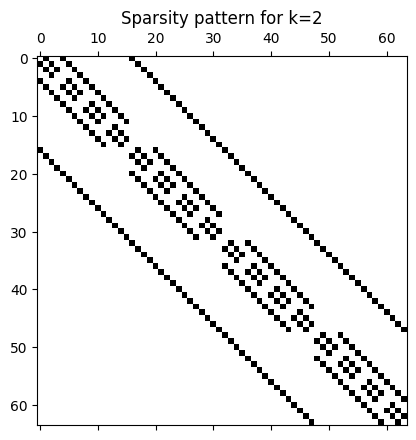

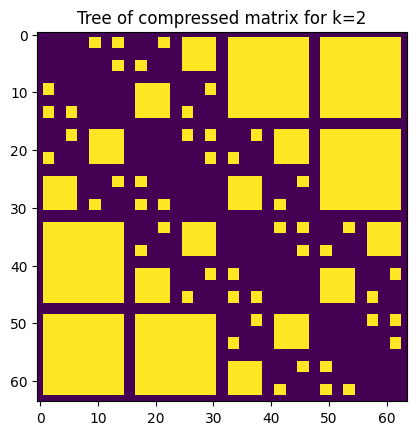

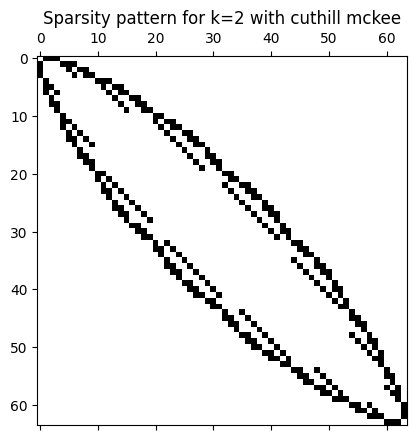

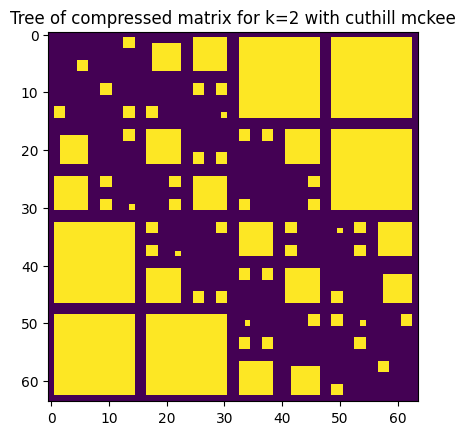

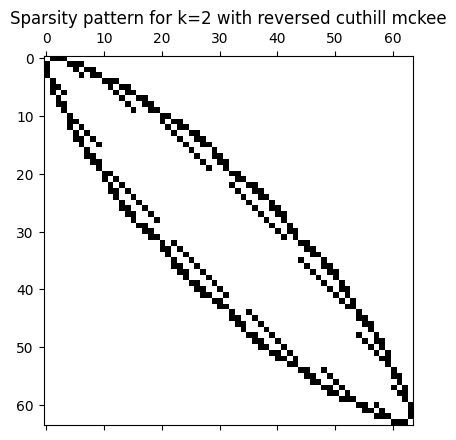

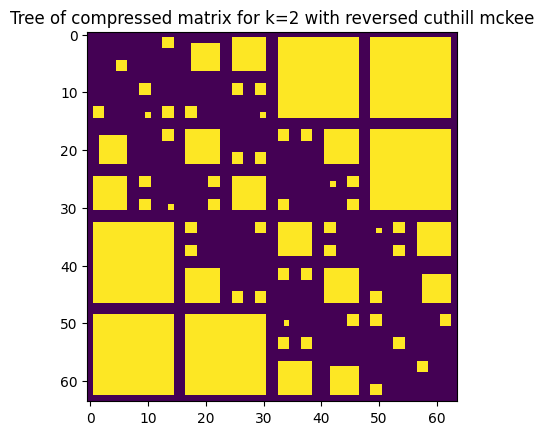

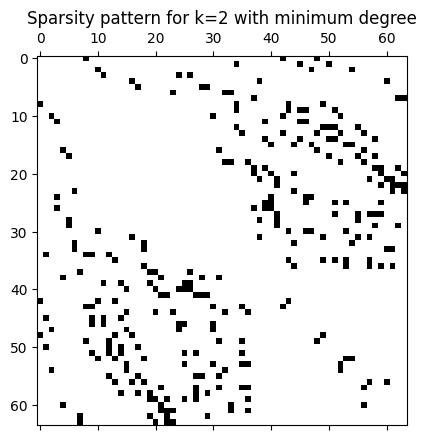

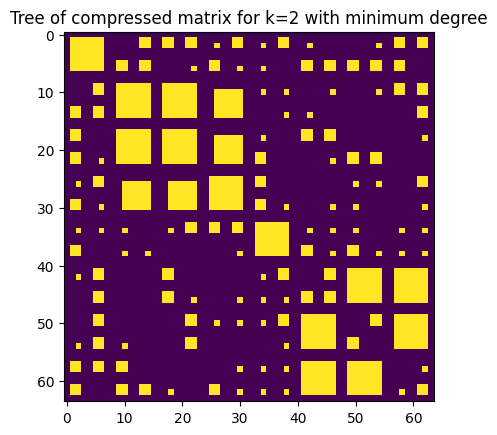

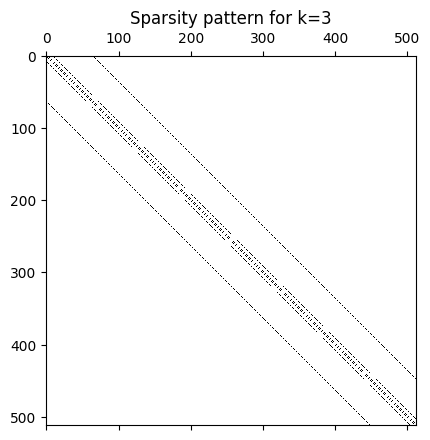

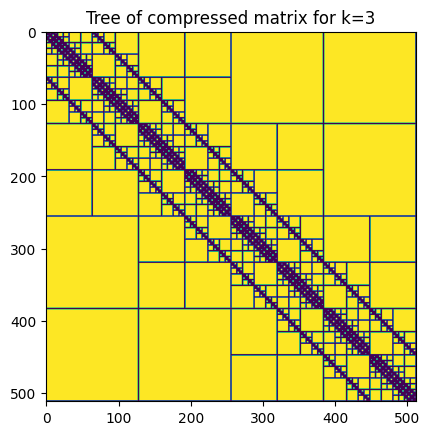

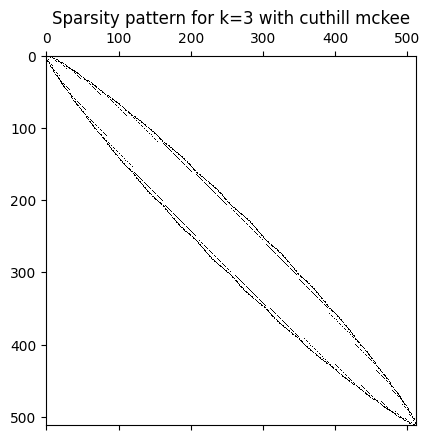

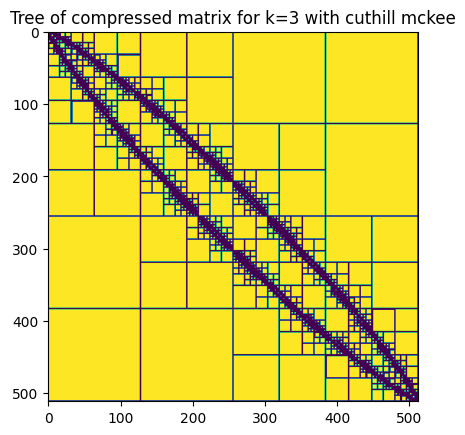

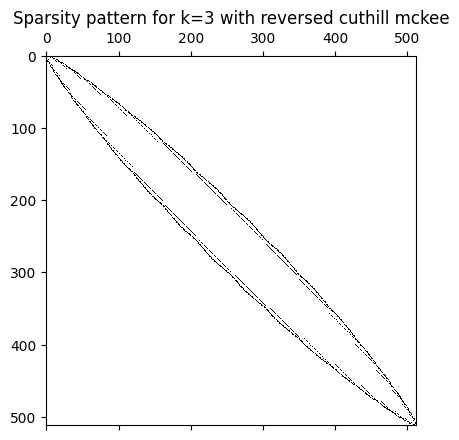

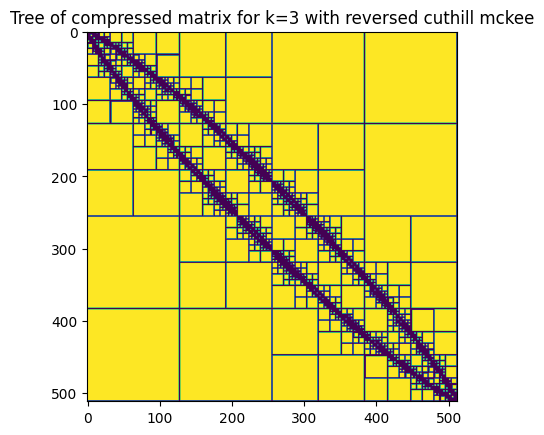

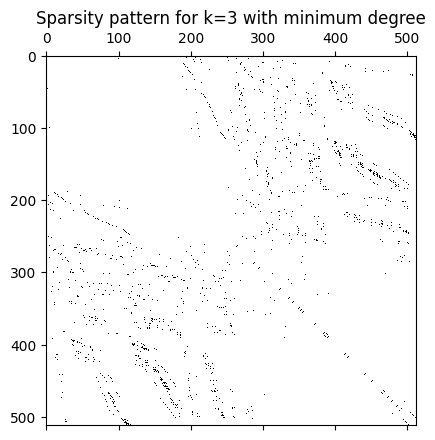

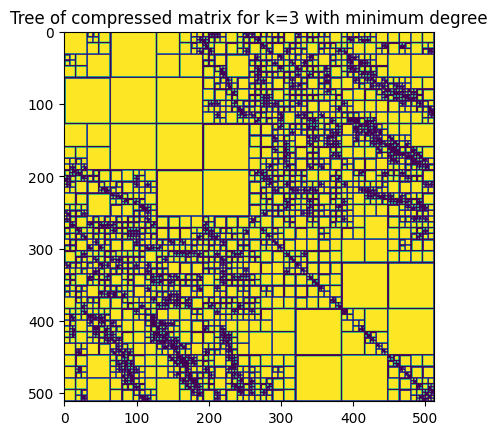

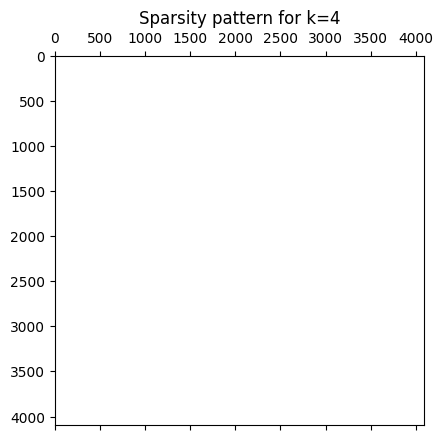

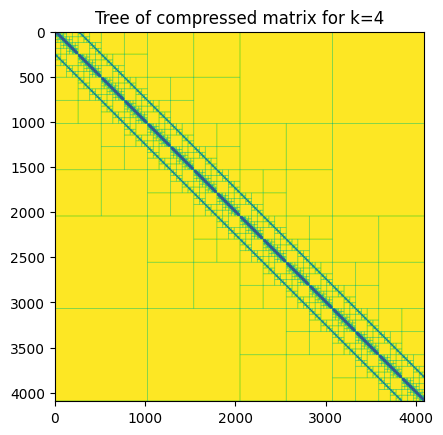

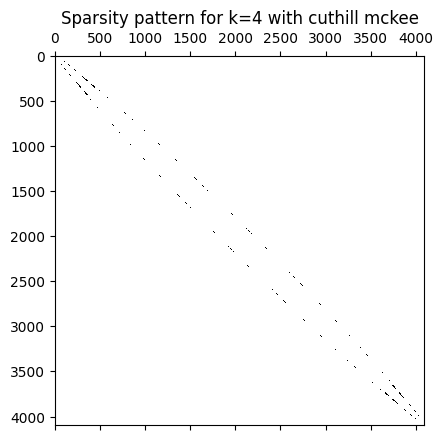

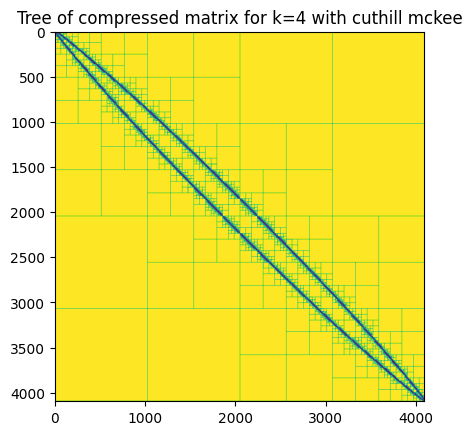

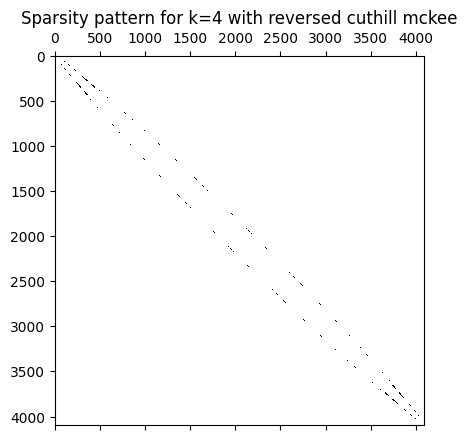

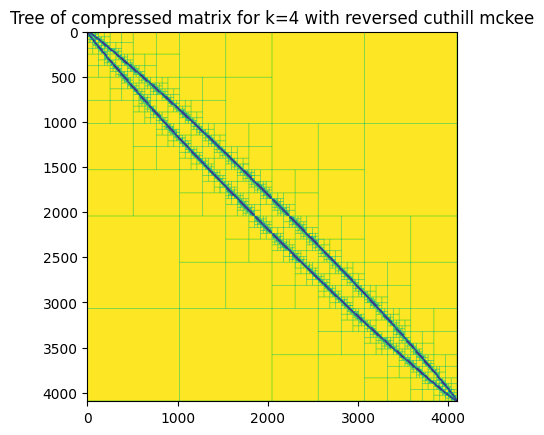

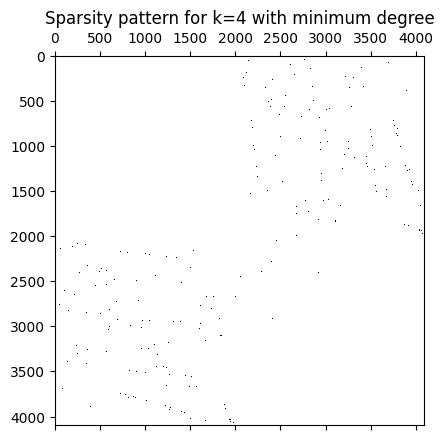

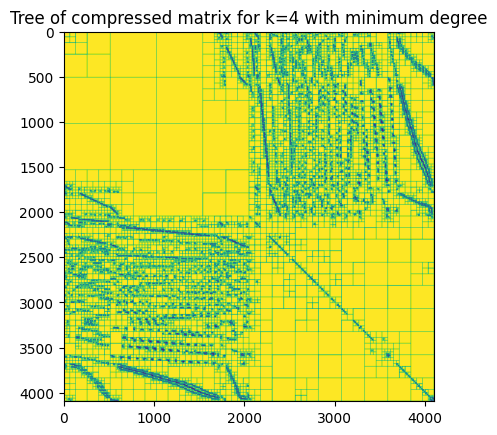

In [37]:

for i in range(len(matrixes)):
    # draw sparsity pattern
    fig, ax = plt.subplots()
    ax.spy(matrixes[i])
    ax.set_title(f"Sparsity pattern for k={i+2}")
    plt.show()
    # draw tree of compressed matrix
    fig, ax = plt.subplots()
    ax.imshow(create_tree_image(matrixes_compressed[i]))
    ax.set_title(f"Tree of compressed matrix for k={i+2}")
    plt.show()

    # draw sparsity pattern for permutated matrix
    for j in range(3):
        fig, ax = plt.subplots()
        ax.spy(matrixes_permutated[i][j])
        ax.set_title(f"Sparsity pattern for k={i+2} with {['cuthill mckee','reversed cuthill mckee','minimum degree'][j]}")
        plt.show()
        # draw tree of compressed matrix
        fig, ax = plt.subplots()
        ax.imshow(create_tree_image(matrixes_permutated_compressed[i][j]))
        ax.set_title(f"Tree of compressed matrix for k={i+2} with {['cuthill mckee','reversed cuthill mckee','minimum degree'][j]}")
        plt.show()

### Porównanie stopnia kompresji macierzy 

In [47]:
import pandas as pd

df = pd.DataFrame(columns=['k','no permutation', 'cuthill mckee', 'reversed cuthill mckee', 'minimum degree'])
for i in range(len(matrixes_compressed)):
    new_row = pd.DataFrame({'k': [i+2],
                            'no permutation': [matrixes_compressed[i].compute_ratio()],
                            'cuthill mckee': [matrixes_permutated_compressed[i][0].compute_ratio()],
                            'reversed cuthill mckee': [matrixes_permutated_compressed[i][1].compute_ratio()],
                            'minimum degree': [matrixes_permutated_compressed[i][2].compute_ratio()]})
    df = pd.concat([df, new_row], ignore_index=True)


df.style.set_caption("Compression ratio for different permutations")
df.style.hide(axis='index')

,k,no permutation,cuthill mckee,reversed cuthill mckee,minimum degree
0,2,3.723636,2.580970,2.580970,1.570552
1,3,22.260870,15.784200,15.784200,5.427187
2,4,146.285714,109.271485,109.271485,27.580224


### Wnioski 

Każdy wzorzec rzadkości dla każdej macierzy przed kompresją dla każdego algorytmu permutacji zdaje się odpowiadać skompresowanej macierzy hierarchicznej. Oba algorytmy zdają się działać poprawnie. Minimal degree te wartości niezerowe rozrzuca bardziej po macierzy i dane są dalej od przekątnej niż normalnie. Cuthill mckee oraz jego wersja reversed układa je w formie elipsy/wstęgi, co jest poprawne. 
Kompresja mocno zależy od algorytmu, aczkolwiek wyszło, że najlepszy stopień udało się uzyskać przy braku permutacji, najgorzej dla algorytmu minimum degree, a tak średnio (gdzie oba wyszły tak samo) dla cuthull mckee oraz jego wersji reversed